# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [10]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [11]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [12]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [13]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [14]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        print(f"epoch #{epoch}")
        if scheduler is not None:
            print(f"lr: {scheduler.get_last_lr()}")

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        if scheduler is not None:
            scheduler.step()
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        predictions = model(x)
        correct_samples += torch.sum(torch.argmax(predictions, 1) == y)
        total_samples += y.shape[0]
    
    return correct_samples / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

epoch #0
Average loss: 1.820072, Train accuracy: 0.411989, Val accuracy: 0.554024
epoch #1
Average loss: 1.451537, Train accuracy: 0.591526, Val accuracy: 0.601802
epoch #2
Average loss: 1.372725, Train accuracy: 0.623537, Val accuracy: 0.630674


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [15]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10), 
)
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

epoch #0
Average loss: 2.178704, Train accuracy: 0.203887, Val accuracy: 0.236571
epoch #1
Average loss: 2.008610, Train accuracy: 0.274904, Val accuracy: 0.306054
epoch #2
Average loss: 1.846312, Train accuracy: 0.342491, Val accuracy: 0.381134
epoch #3
Average loss: 1.737362, Train accuracy: 0.403679, Val accuracy: 0.412600
epoch #4
Average loss: 1.694016, Train accuracy: 0.425332, Val accuracy: 0.437240


Добавьте слой с Batch Normalization

In [16]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

epoch #0
Average loss: 2.059865, Train accuracy: 0.301693, Val accuracy: 0.427684
epoch #1
Average loss: 1.770139, Train accuracy: 0.465618, Val accuracy: 0.522626
epoch #2
Average loss: 1.638452, Train accuracy: 0.535235, Val accuracy: 0.580029
epoch #3
Average loss: 1.550632, Train accuracy: 0.575624, Val accuracy: 0.601870
epoch #4
Average loss: 1.493453, Train accuracy: 0.604904, Val accuracy: 0.622210


Добавьте уменьшение скорости обучения по ходу тренировки.

In [17]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, 0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

epoch #0
lr: [0.001]
Average loss: 2.061460, Train accuracy: 0.311419, Val accuracy: 0.431506
epoch #1
lr: [0.001]
Average loss: 1.753950, Train accuracy: 0.474064, Val accuracy: 0.536141
epoch #2
lr: [0.0005]
Average loss: 1.634381, Train accuracy: 0.543477, Val accuracy: 0.574090
epoch #3
lr: [0.0005]
Average loss: 1.577710, Train accuracy: 0.571358, Val accuracy: 0.603781
epoch #4
lr: [0.00025]
Average loss: 1.536369, Train accuracy: 0.592192, Val accuracy: 0.611904


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [18]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetSampler(indices))
    
    predictions = []
    ground_truth = []
    for x, y in loader:       
        y_model = torch.argmax(model(x), 1)
        
        predictions.append(y_model)
        ground_truth.append(y)
    
    return np.concatenate([p.numpy() for p in predictions]), np.concatenate([gt.numpy() for gt in ground_truth])

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

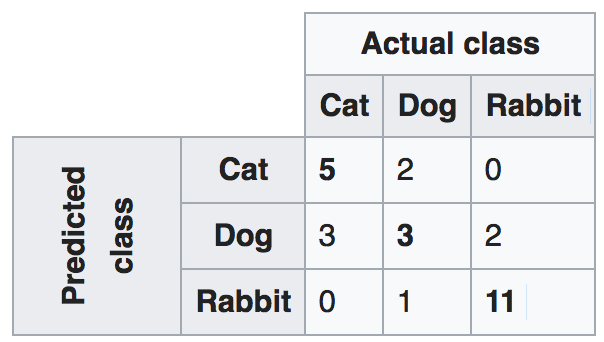

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

/tmp/ipykernel_57312/463954532.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  confusion_matrix = np.zeros((10,10), np.int)


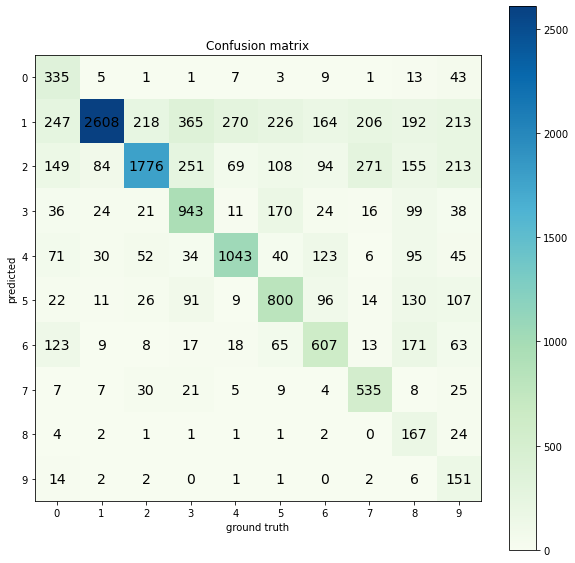

In [19]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    np.add.at(confusion_matrix, (predictions, ground_truth), 1)
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

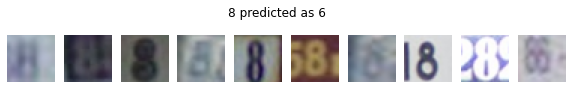

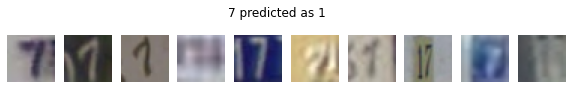

In [20]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    indices = val_indices[(predictions == predicted_class) & (ground_truth == gt_class)]
    visualize_images(indices, data, f"{gt_class} predicted as {predicted_class}")

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [21]:
def batched_train_val_loaders(data_train, batch_size):
    data_size = data_train.data.shape[0]
    validation_split = .2
    split = int(np.floor(validation_split * data_size))
    indices = list(range(data_size))
    np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

In [22]:
import math
import random

class IntGenerator:
    def __init__(self, generator):
        self.gen = generator

    def next(self):
        return int(round(self.gen.next()))

class LinHPGenerator:
    def __init__(self, lower, upper = None):
        if upper is None:
           upper = lower
        self.lower = lower
        self.upper = upper

    def next(self):
        return self.lower + random.random() * (self.upper - self.lower)

class LogHPGenerator:
    def __init__(self, lower, upper = None):
        if upper is None:
           upper = lower
        self.lin_gen = LinHPGenerator(math.log10(lower), math.log10(upper))

    def next(self):
        return 10 ** self.lin_gen.next()

epoch #0
lr: [0.001]
Average loss: 1.287780, Train accuracy: 0.581476, Val accuracy: 0.717835
epoch #1
lr: [0.00085]
Average loss: 0.854846, Train accuracy: 0.731529, Val accuracy: 0.768480
epoch #2
lr: [0.0007224999999999999]
Average loss: 0.711129, Train accuracy: 0.778692, Val accuracy: 0.795987
epoch #3
lr: [0.000614125]
Average loss: 0.631731, Train accuracy: 0.802051, Val accuracy: 0.808341
epoch #4
lr: [0.00052200625]
Average loss: 0.567095, Train accuracy: 0.823550, Val accuracy: 0.828339
epoch #5
lr: [0.00044370531249999997]
Average loss: 0.521742, Train accuracy: 0.838157, Val accuracy: 0.830933
epoch #6
lr: [0.00037714951562499996]
Average loss: 0.480752, Train accuracy: 0.850408, Val accuracy: 0.834141
epoch #7
lr: [0.00032057708828124994]
Average loss: 0.445681, Train accuracy: 0.861482, Val accuracy: 0.839738
epoch #8
lr: [0.0002724905250390624]
Average loss: 0.418989, Train accuracy: 0.868529, Val accuracy: 0.844243
epoch #9
lr: [0.00023161694628320305]
Average loss: 0.3

No handles with labels found to put in legend.


Average loss: 0.217062, Train accuracy: 0.936986, Val accuracy: 0.860010


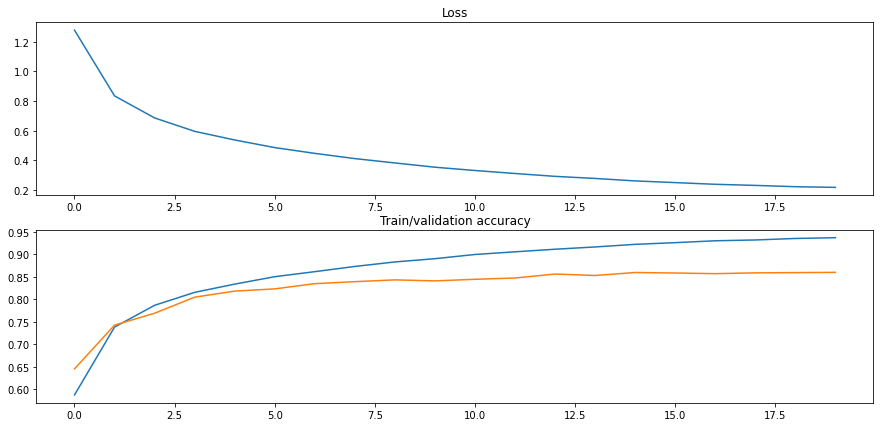

In [23]:
# Итак чтобы достигнуть точности >80% надо:
# 1) Скопировать параметры из предыдущего задания
# 2) Profit!
# 3) Потратить уйму времени пытаясь сделать лучше
from dataclasses import dataclass, fields
import itertools


@dataclass
class HyperParameters:
    lr: float
    reg: float
    lr_decay: float
    batch_size: int
    layer1: int
    layer2: int


def model_for_hp(hp):
    nn_model = nn.Sequential(
        Flattener(),

        nn.Linear(3*32*32, hp.layer1),
        nn.BatchNorm1d(hp.layer1),
        nn.ReLU(inplace=True),

        nn.Linear(hp.layer1, hp.layer2),
        nn.BatchNorm1d(hp.layer2),
        nn.ReLU(inplace=True),

        nn.Linear(hp.layer2, 10),
    )
    nn_model.type(torch.FloatTensor)

    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    optimizer = optim.Adam(nn_model.parameters(), lr=hp.lr, weight_decay=hp.reg)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, hp.lr_decay)
    train_val_loaders = batched_train_val_loaders(data_train, hp.batch_size)
    return train_model(nn_model, *train_val_loaders, loss, optimizer, 20, scheduler), nn_model


lr_gen = LogHPGenerator(1e-3)#(1e-5, 1e-1)#1e-3
reg_gen = LogHPGenerator(5e-7)#(1e-7, 1e-1) # 1e-6
lr_decay_gen = LogHPGenerator(0.85) # (0.5, 1.0)->0.85
batch_size_gen = IntGenerator(LogHPGenerator(32, 256)) # 128
layer1_gen = IntGenerator(LogHPGenerator(448)) # (32, 512)->448 better than 256
layer2_gen = IntGenerator(LogHPGenerator(256, 512)) # (32, 512)->448 better than 128

hps = [
    HyperParameters(
        lr_gen.next(),
        reg_gen.next(),
        lr_decay_gen.next(),
        batch_size_gen.next(),
        layer1_gen.next(),
        layer2_gen.next(),
    )
    for _ in range(5)
]

result = {f.name: {} for f in fields(HyperParameters)}
best_accuracy = -1.0
for hp in hps:
    (loss_history, train_history, val_history), nn_model = model_for_hp(hp)
    accuracy = val_history[-1]
    for f in fields(HyperParameters):
        result[f.name][getattr(hp, f.name)] = accuracy
    if accuracy > best_accuracy:
        best_loss_history, best_train_history, best_val_history, best_nn_model = loss_history, train_history, val_history, nn_model


plt.figure(figsize=(15, 7))
plt.legend()
plt.subplot(211)
plt.title("Loss")
plt.plot(best_loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(best_train_history, label="Train")
plt.plot(best_val_history, label="Val")

{'lr': {0.001: tensor(0.8600)},
 'reg': {5e-07: tensor(0.8600)},
 'lr_decay': {0.85: tensor(0.8600)},
 'batch_size': {55: tensor(0.8647),
                115: tensor(0.8627),
                190: tensor(0.8626),
                36: tensor(0.8644),
                167: tensor(0.8600)},
 'layer1': {448: tensor(0.8600)},
 'layer2': {270: tensor(0.8647),
            349: tensor(0.8627),
            286: tensor(0.8626),
            381: tensor(0.8644),
            330: tensor(0.8600)}}


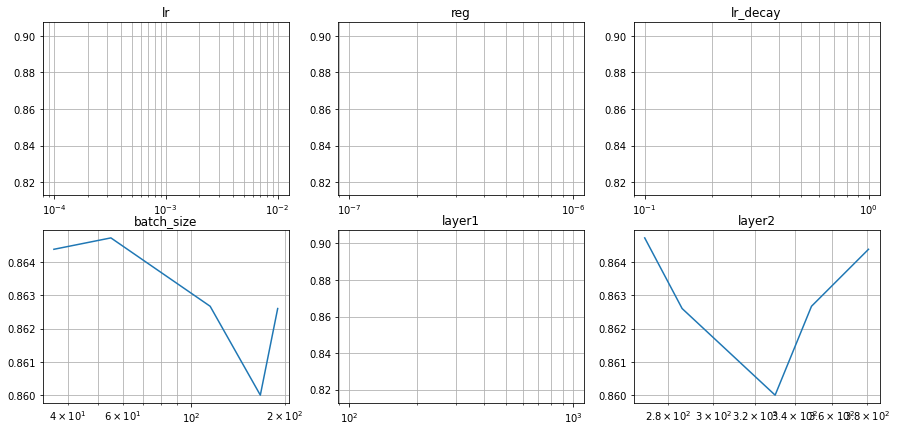

In [24]:
from pprint import pp

pp(result)

plt.figure(figsize=(15, 7))
for i, (name, res) in enumerate(result.items()):
    plt.subplot(2, (len(fields(HyperParameters)) + 1) // 2, i + 1)
    plt.title(name)
    plt.grid(b=True, which='major')
    plt.grid(b=True, which='minor')
    res = np.array(list(sorted(result[name].items(), key=lambda kv: kv[0])))
    plt.plot(res[:, 0], res[:, 1])
    #if name in ('lr', 'reg', 'lr_decay'):
    plt.xscale('log')

/tmp/ipykernel_57312/463954532.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  confusion_matrix = np.zeros((10,10), np.int)


[0.9346633416458853, 0.9495517665670592, 0.9549295774647887, 0.9105263157894737, 0.9491997216423104, 0.9226461323066153, 0.9100671140939597, 0.9436819687647894, 0.9183070866141733, 0.9047881122729774]


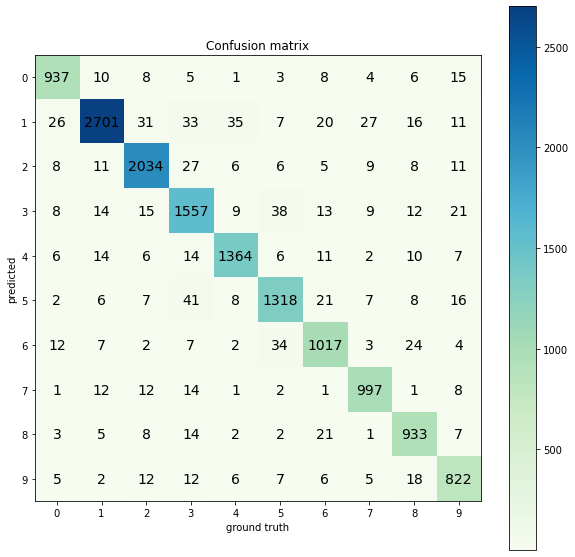

In [26]:
predictions, gt = evaluate_model(best_nn_model, data_train, val_indices)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)
f1s = []
for i_class in range(10):
    others = np.arange(10) != i_class
    tp = confusion_matrix[i_class, i_class]
    fp = np.sum(confusion_matrix[i_class, others])
    tn = np.sum(confusion_matrix[others, others])
    fn = np.sum(confusion_matrix[others, i_class])
    f1s.append(tp / (tp + (fp + fn) / 2))
print(f1s)

In [25]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(best_nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8433
